In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the data
data = pd.read_csv('aws_ec2_instance_metric_cpu_utilization_daily.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [3]:
# Use 'maximum' column for prediction
data = data[['maximum']]
data = data.resample('D').mean()
data = data.fillna(method='ffill')

C:\Users\Amit\AppData\Local\Temp\ipykernel_22260\2098103030.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [4]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [6]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [7]:
look_back = 30
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

In [8]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2)

Epoch 1/100
4/4 - 2s - loss: 0.0721 - 2s/epoch - 535ms/step
Epoch 2/100
4/4 - 0s - loss: 0.0398 - 89ms/epoch - 22ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0222 - 83ms/epoch - 21ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0264 - 65ms/epoch - 16ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0233 - 67ms/epoch - 17ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0206 - 75ms/epoch - 19ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0211 - 66ms/epoch - 17ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0213 - 64ms/epoch - 16ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0207 - 65ms/epoch - 16ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0199 - 67ms/epoch - 17ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0197 - 68ms/epoch - 17ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0197 - 69ms/epoch - 17ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0195 - 73ms/epoch - 18ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0193 - 66ms/epoch - 16ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0192 - 69ms/epoch - 17ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0191 - 69ms/epoch - 17ms/step
Epoch 17/100
4/4 -

In [10]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform to the original scale

rmse = np.sqrt(mean_squared_error(data[train_size + look_back:], y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

1/1 [==============================] - 0s 456ms/step
Root Mean Squared Error (RMSE): 16.028639127567367


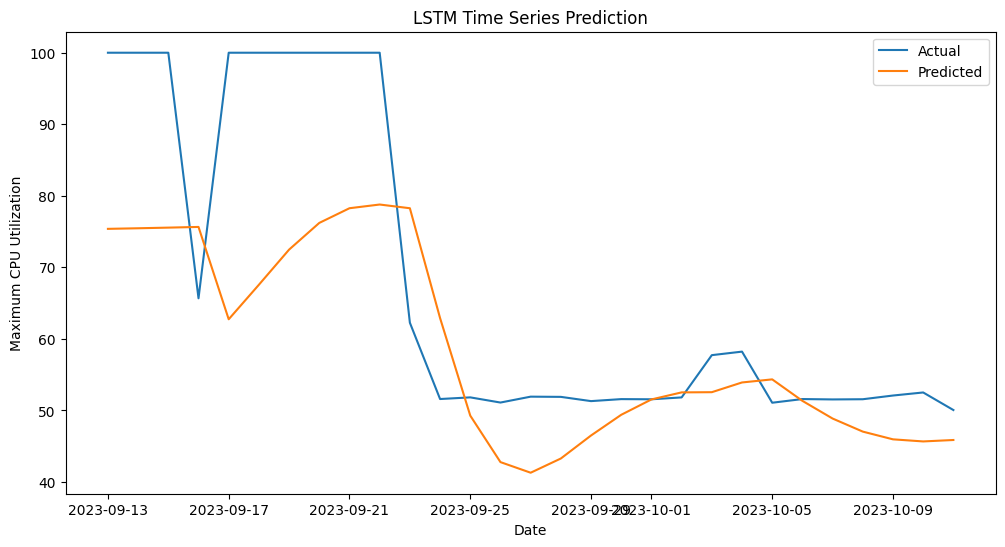

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + look_back:], data[train_size + look_back:], label='Actual')
plt.plot(data.index[train_size + look_back:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum CPU Utilization')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.show()